In [11]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import re

# function used to fit complexity curve
from scipy.optimize import curve_fit

# function used to calculate minimum of RSS 
from sklearn.linear_model import LinearRegression

parameters 

In [57]:
## global parameters

## algoritms 

# sorting free symbols
def sorted_symbols(eq_sp):
    symbols = list(eq_sp.free_symbols)

    # Funkcja pomocnicza do sortowania
    def sorting_key(symbol):
        name = str(symbol)

        # Jeśli zmienna ma format np. b0, b1, b10 itd.
        match = re.match(r"([a-zA-Z]+)(\d+)", name)
        if match:
            prefix = match.group(1)  # np. 'b'
            index = int(match.group(2))  # np. 10
            return (prefix, index)  # np. ('b', 10)

        # W przeciwnym wypadku traktuj jako czysty tekst
        return (name, -1)

    # Sortowanie zmiennych według ustalonego klucza
    sorted_symbols = sorted(symbols, key=sorting_key)
    return sorted_symbols

## plots 
GD_NAME = 'Metoda spadku gradientu'
SGD_NAME = 'Metoda stochastycznego gradientu'
MGD_NAME = 'Metoda z momentum'
ADAM_NAME = 'Metoda Adam'

point_color = 'red'
arrow_color = 'black'
cmap_surfaces = 'viridis'
min_color = 'purple' # set for cmap lowest value !!!

## approximation
lower_cut = 10 # starting point of aproximation 


### Methods

#### Algorithms

In [138]:
def gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = sorted_symbols(func_sp)
    x = np.array(x0)

    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    # lambdify gradient 
    grad = sp.lambdify(symbols, grad)

    # iterating 
    for _ in range(max_iter):
        next_x = x - learning_rate * np.array(grad(*x.tolist()))
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
    return np.array(history)

In [132]:
def stochatic_gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = sorted_symbols(func_sp)
    x = np.array(x0)

    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    print(grad)
    grad = sp.lambdify(symbols, grad)
    print(grad)
    print(grad(1,0))
    print(grad(0,1))
    print(grad(1, 1))

    # iterating 
    for _ in range(max_iter):
        # chosing space
        i = np.random.randint(0, len(x))
        # creating empty array 
        x_i = np.zeros(x.shape)
        # to empty array of equivalent size we asign value 
        x_i[i] = x[i]
        # calculating next point
        next_x = x - learning_rate * np.array(grad(*x_i.tolist()))
        print(next_x)
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
    return np.array(history)

In [108]:
def momentum_gradient_descent(x0, beta, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = sorted_symbols(func_sp)
    x = np.array(x0)
    m = 0
    
    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    # lambdify gradient 
    grad = sp.lambdify(symbols, grad)
    
    # iterating  
    for _ in range(max_iter):
        # finding momentum
        next_m = beta * m + (1- beta) * np.array(grad(*x.tolist()))
        # calculating new point
        next_x = x - learning_rate * next_m 
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
        m = next_m 
    return np.array(history)

In [109]:
def adam_gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6, b1=0.9, b2=0.999, epsilon = 1e-8):
    # local variables
    history = [x0]
    symbols = sorted_symbols(func_sp) 
    x = np.array(x0)
    m = 0
    v = 0
    
    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    # lambdify gradient 
    grad = sp.lambdify(symbols, grad)
    
    # iterating  
    for t in range(1, max_iter + 1): # we need to move index by one because we divide by zero
        # finding moments
        g = np.array(grad(*x.tolist()))
        m = b1 * m + (1 - b1) * g
        m_hat = m / (1 - b1**t)
        v = b2 * v + (1- b2) * g**2
        v_hat = v / (1  -b2**t)
        # calculating new point 
        next_x = x - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
        
    return np.array(history)

#### Plots

In [110]:

def plot_3d(func: callable, func_g: list, interval: list, min_point: list, func_name: str, method_name: str):
    # local variables
    a, b = interval
    dens = int(np.ceil(b - a) * 10)
    # initiating 
    fig ,ax = plt.subplots(subplot_kw={'projection': '3d'})
    arg_range = np.linspace(a, b, dens)
    xx, yy = np.meshgrid(arg_range, arg_range)
    z = func(xx, yy)

    # plotting 
    ax.plot_surface(xx, yy, z, cmap=cmap_surfaces, alpha=0.7)

    # gradient trajectory 
    ax.scatter(func_g[:, 0], func_g[:, 1], func(func_g[:, 0], func_g[:, 1]), color=point_color)
    ax.scatter(*min_point, color=min_color)

    # arrows indicating move 
    for i in range(len(func_g) - 1):
        # values 
        x, y, x_n, y_n = *func_g[i, :], *func_g[i + 1, :]
        ax.quiver(x, y, func(x, y),
                x_n - x, y_n - y, func(x_n, y_n) - func(x, y), 
                color=arrow_color, arrow_length_ratio=0.1, alpha=0.7)

    # description 
    ax.set_title(f"{method_name} od {func_name}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    plt.show()

In [111]:
def plot_3d_on_2d(func: callable, func_g: list, interval: list, min_point: list, func_name: str, method_name: str, index=None, save=False):
    # creating local variables 
    a, b = interval
    dens = int(np.ceil(b-a) * 10)
    # initiating 
    arg_range = np.linspace(a, b, dens)
    xx, yy = np.meshgrid(arg_range, arg_range)
    z = func(xx, yy)
    # tutaj trzeba ustalić skale lvl ~ na na ile wartości bierzemy CZYLI, chcemy zawsze żeby nam skalował np że okręgi co 1


    contour = plt.contour(xx, yy, z, cmap=cmap_surfaces)
    plt.clabel(contour, inline=True, fontsize=8)

    # gradient trajectories 
    plt.scatter(func_g[:, 0], func_g[:, 1], color=point_color, label='Gradient Path')
    plt.scatter(*min_point, color=min_color)
    # gradient arrows 
    for i in range(len(func_g) - 1):
        x, y, x_n, y_n = *func_g[i, :], *func_g[i+1, :]
        plt.quiver(x, y, 
                x_n - x, y_n - y,
                angles='xy', scale_units='xy', scale=1.15, color=arrow_color, alpha=0.4)
    
    # adding index 


    # display 
    plt.title(f"{method_name} od ${func_name}$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.grid(True)

    # plot save 
    index = f'_iter_{index}' if index else ''
    if save:
        plt.savefig(f'{method_name}_{func_name}{index}.png', dpi=100, bbox_inches="tight")

    plt.show()




In [150]:
def plot_complexity(dist: list, func_t: callable, func_t_param: list, complexity: str, name: str):
    """
    Funkcja rysująca porównanie zbieżności metody gradientu z teoretyczną złożonością.

    Parametry:
    - dist (list): Lista odległości w każdej iteracji.
    - func_t (callable): Teoretyczna funkcja zbieżności.
    - func_t_param (list): Lista symboli funkcji (parametry).
    - complexity (str): Opis teoretycznej złożoności.
    - m (str): Format zapisu wykresu (np. 'png', 'jpg', 'svg').
    """
    # Local variables
    n = len(dist)
    x = sp.Symbol('x')

    # domains
    dom_dis = [i for i in range(n)]
    dom_con = np.linspace(1, n, (n-1) * 10)

    # lambify functnio
    func_t_lamb = sp.lambdify((x, *func_t_param), func_t)
    # fitting curve to plot
    popt, _ = curve_fit(func_t_lamb, dom_dis[lower_cut:], dist[lower_cut:])
    # creating str for theoritcal function
    func_t_names = {key: format(value, '.2g') 
                    for key, value in zip(func_t_param, popt)}
    func_t_name = sp.latex(func_t.subs(func_t_names))

    # plot
    plt.figure(figsize=(16, 9))
    # real data 
    plt.plot(dom_dis, dist, label='Rzeczywista odległość vs iteracja', 
             color='blue', marker='o', linestyle='-', linewidth=2)
    # fitted function 
    plt.plot(dom_con, func_t_lamb(dom_con, *popt), 
             label=f'Teoretyczna złożoność: {complexity}\n${func_t_name}$', 
             color='red', linestyle='--', linewidth=2)

    # plot setting 
    plt.title(f'Porównanie rzeczywistej zbieżności z teoretyczną złożonością\nZłożoność: {complexity}', fontsize=16)
    plt.xlabel('Iteracja', fontsize=14)
    plt.ylabel('Odległość', fontsize=14)
    plt.ylim(-1, 40)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=12)

    # plot save 

    plt.savefig(f'{name}.png', dpi=100)
    plt.show()



    


### Tests

#### help function

In [157]:
def complexity_raport(x_init: list, x_final: list, func_sp: sp.Function, 
                      learning_rate: float, n_iter: int, tol,
                      b = 0.9, b1 = 0.9, b2 = 0.999):
    
    # calculating aproximations 
    tf_g_val_gd = gradient_descent(x_init, func_sp, learning_rate, n_iter, tol)
    tf_g_val_sgd = stochatic_gradient_descent(x_init, func_sp, learning_rate, n_iter, tol)
    tf_g_val_mgd = momentum_gradient_descent(x_init, b, func_sp, learning_rate, n_iter, tol)
    tf_g_val_adam = adam_gradient_descent(x_init, func_sp, learning_rate, n_iter, tol, b1, b2)

    # compare them (distance) to known minimum (analitically)
    dist_gd = abs(tf_g_val_gd - x_final)
    dist_gd = np.sqrt(dist_gd[:, 0]**2 + dist_gd[:, 1]**2)
    dist_sgd = abs(tf_g_val_sgd - x_final)
    dist_sgd = np.sqrt(dist_sgd[:, 0]**2 + dist_sgd[:, 1]**2)
    dist_mgd = abs(tf_g_val_mgd - x_final)
    dist_mgd = np.sqrt(dist_mgd[:, 0]**2 + dist_mgd[:, 1]**2)
    dist_adam = abs(tf_g_val_adam - x_final)
    dist_adam = np.sqrt(dist_adam[:, 0]**2 + dist_adam[:, 1]**2)

    x, a, b = sp.symbols('x, a, b')
    plot_complexity(dist_gd, a/x + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t})$', GD_NAME)
    plot_complexity(dist_sgd, a/x**2 + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t^2})$', SGD_NAME)
    plot_complexity(dist_mgd,a/x**2 + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t^2})$', MGD_NAME)
    plot_complexity(dist_adam, a/x**(1/2) + b, (a, b), 'Złożoność $\mathcal{O}((1/\sqrt{t}))$', ADAM_NAME)

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7094/513398497.py:22: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_gd, a/x + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t})$', GD_NAME)
/tmp/ipykernel_7094/513398497.py:23: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_sgd, a/x**2 + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t^2})$', SGD_NAME)
/tmp/ipykernel_7094/513398497.py:24: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_mgd,a/x**2 + b, (a, b), 'Złożoność $\mathcal{O}(\\frac{1}{t^2})$', MGD_NAME)
/tmp/ipykernel_7094/513398497.py:25: SyntaxWarning: in

#### functions

Convergence test for $\mathcal{O}$ with:
- RSS
- Standard function
- check which function they use

RSS

[[16.64478825]
 [15.24790865]
 [15.64207407]]
[15.  2.]
[6.0*b_0 + 2.53477097826649*b_1 - 95.069541956533, 2.53477097826649*b_0 + 1.58952310922466*b_1 - 41.2006108924466]
<function _lambdifygenerated at 0x7100aac93920>
[-89.069541956533, -38.66583991418011]
[-92.53477097826651, -39.61108778322194]
[-86.53477097826651, -37.07631680495545]
[13.5069542  29.58529011]
[15.51471492 29.00270097]
[17.67014864 28.51271572]
[16.57501365 28.15379881]
[18.94562463 27.79874852]
[21.40623273 27.50013429]
[23.9425327  27.24898548]
[26.54249313 27.03775736]
[20.12395145 24.42990432]
[17.55653478 23.4490046 ]
[21.11970334 23.84179222]
[17.95483553 22.6084922 ]
[16.68888841 22.17741368]
[20.57437615 22.77232362]
[17.73670465 21.67725155]
[16.60163606 21.30146422]
[16.14760862 21.21339078]
[20.27745408 21.96153438]
[24.21766228 22.59075883]
[19.19401911 20.57219717]
[23.48639247 21.42225998]
[18.90151118 19.58905847]
[23.44308769 20.59539344]
[18.88418927 18.7731687 ]
[23.63257515 19.90919124]
[18.959984

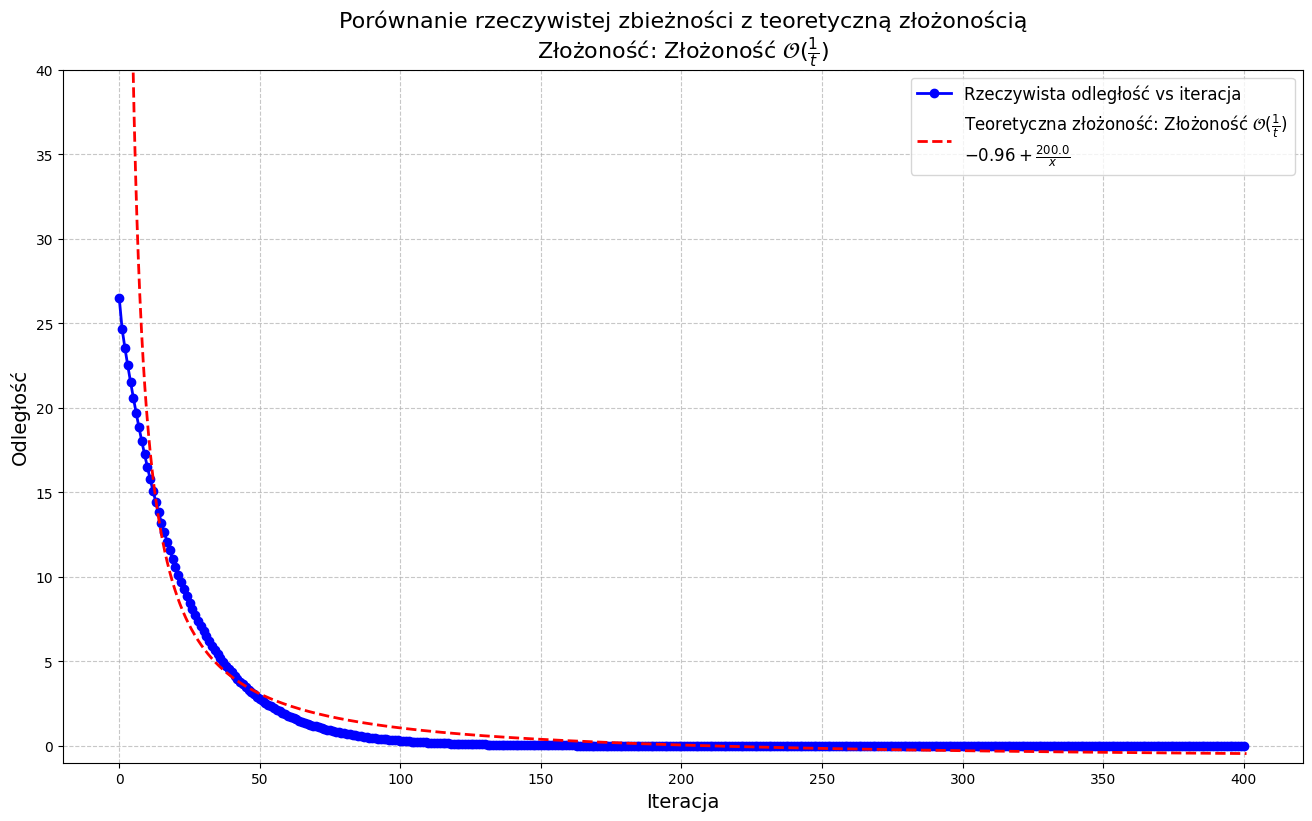

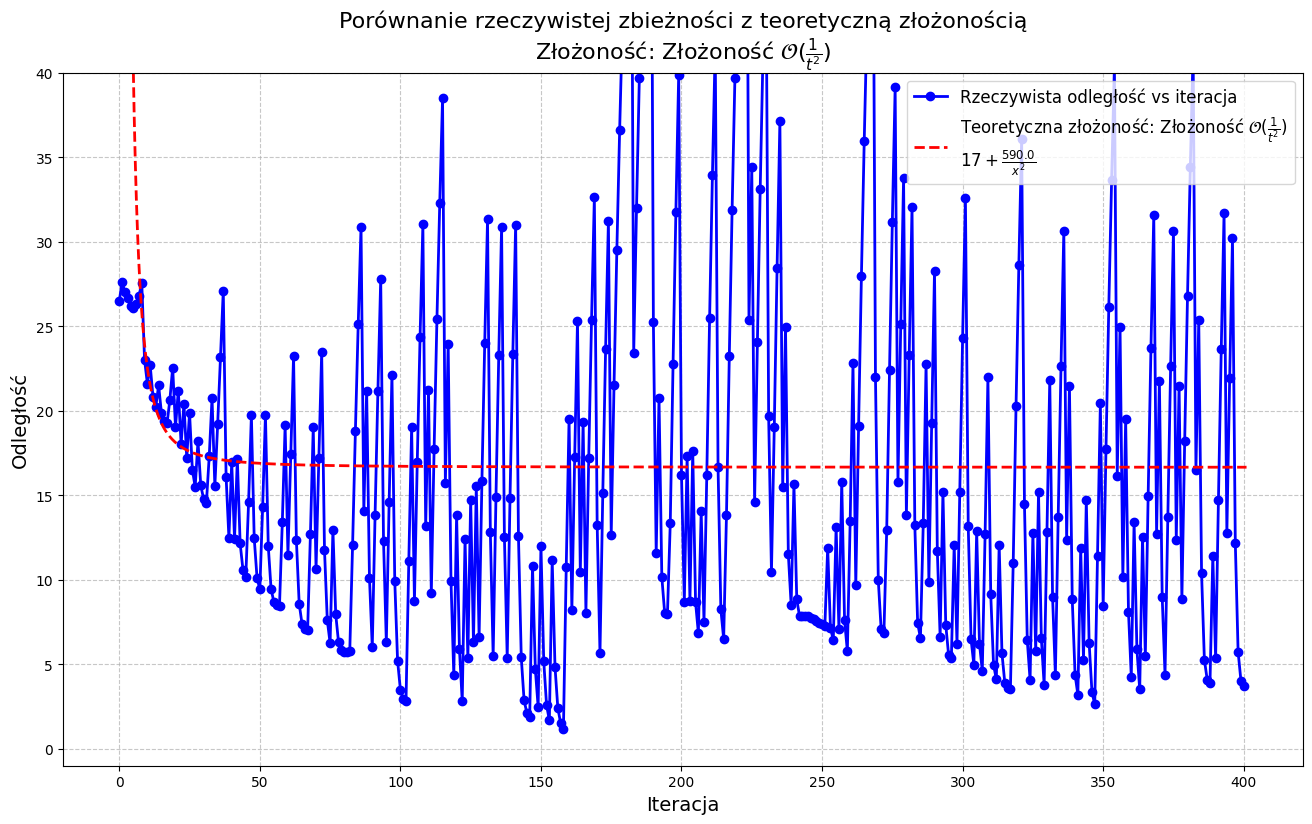

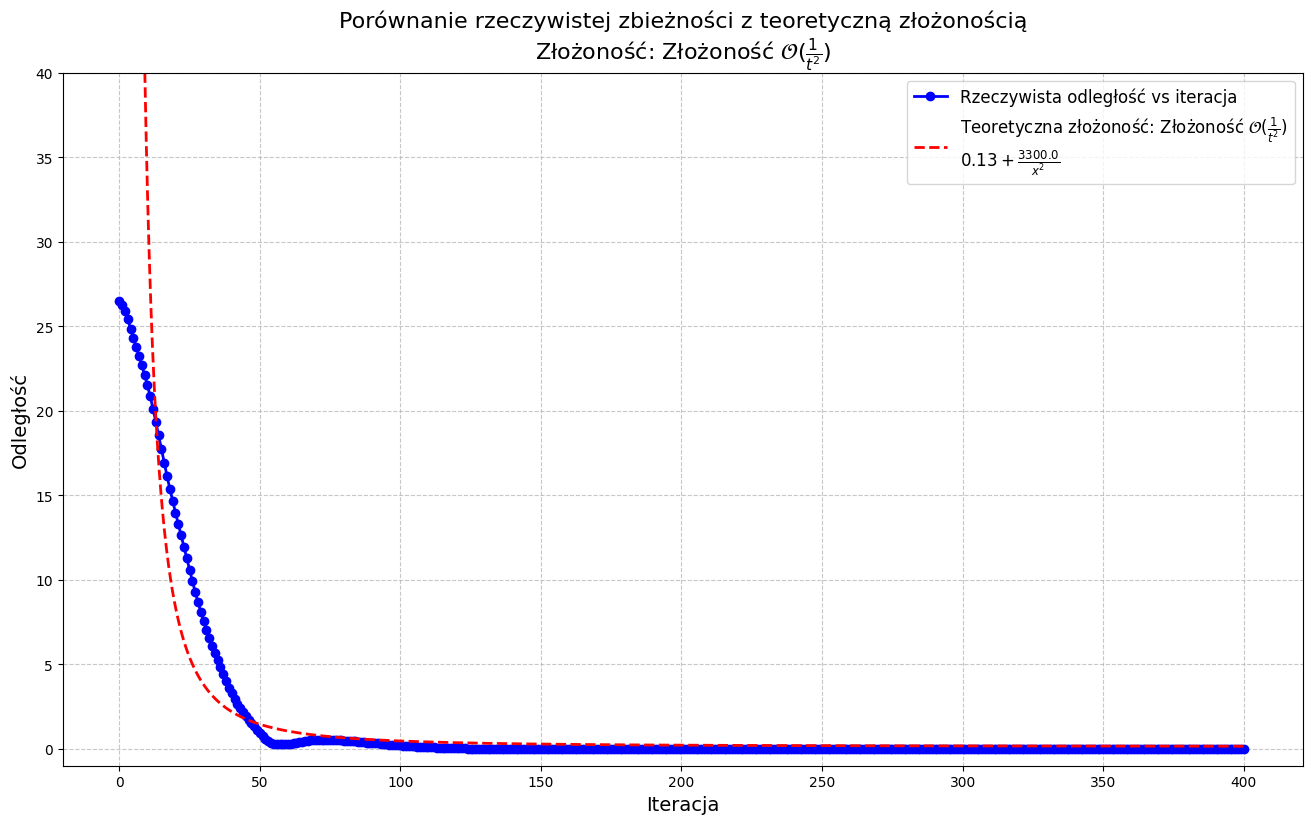

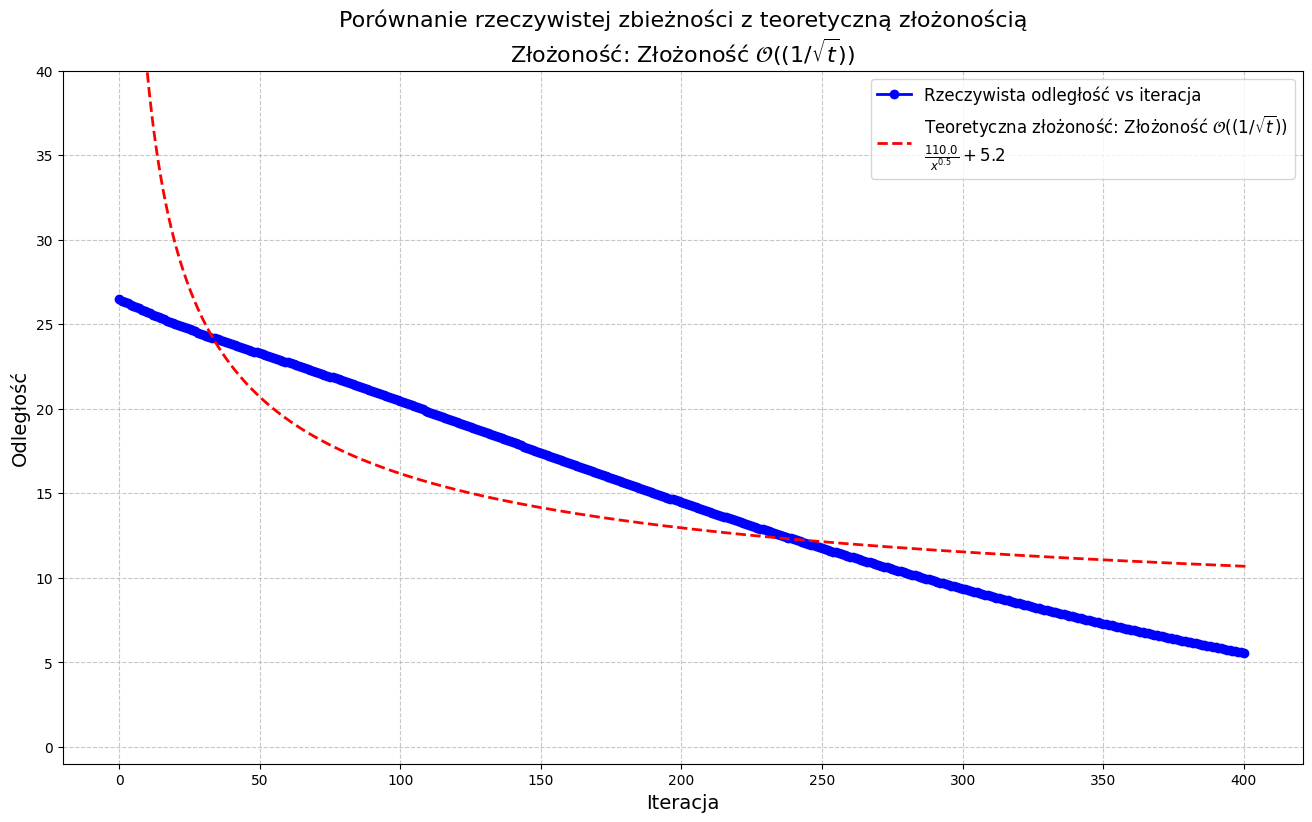

In [160]:
# function parameters
n = 3 # lenght of probe 
m = 1 + 1  # feature amount about zero vector 
bi = sp.symbols(f'b_0:{m}') # estimated values
  
# algorithms parameters 
x0 = (10, 28)
lr = 0.1
n_iter = 400


# creating probe 
X = np.random.uniform(0, 1, n).reshape(-1 ,1)
y = X * 2 + 15
# creating matrix with ones 
X = np.hstack((np.ones(X.shape), X))


# finding x_true
b_true = np.linalg.solve(X.T @ X, X.T @ y).reshape(-1, ) # should be same as coefficent in y

# creating RRS 
RSS = sum((y[i] - X[i, :] @ np.array(bi).reshape(-1, 1))**2 for i in range(n)).item()



print(y)
print(b_true)

# raport
complexity_raport(x0, b_true, RSS, lr, n_iter, None, b=0.9, b1=0.9, b2=0.999)




# TODO, we can add noise later
# TODO, random point and take mean of this calculations ???? ~ 

normal function

[1.0*x, 1.3*y - 0.611]
<function _lambdifygenerated at 0x7100ae5b49a0>
[1.0, -0.611]
[0.0, 0.6890000000000001]
[1.0, 0.6890000000000001]
[ 13.65    -16.78615]
[13.65       -8.93460175]
[13.65       -4.65550795]
[13.65       -2.32340183]
[ 8.8725     -2.10955183]
[ 5.767125   -1.89570183]
[ 5.767125  -0.8193075]
[ 5.767125   -0.23267259]
[5.767125   0.08704344]
[3.74863125 0.30089344]
[3.74863125 0.37783692]
[2.43661031 0.59168692]
[1.5837967  0.80553692]
[1.02946786 1.01938692]
[0.66915411 1.23323692]
[0.43495017 1.44708692]
[0.43495017 1.00251237]
[0.43495017 0.76021924]
[0.43495017 0.62816949]
[0.28271761 0.84201949]
[0.18376645 1.05586949]
[0.11944819 1.26971949]
[0.11944819 0.90584712]
[0.07764132 1.11969712]
[0.07764132 0.82408493]
[0.05046686 1.03793493]
[0.03280346 1.25178493]
[0.02132225 1.46563493]
[0.01385946 1.67948493]
[0.01385946 1.12916929]
[0.01385946 0.82924726]
[0.00900865 1.04309726]
[0.00585562 1.25694726]
[0.00380615 1.47079726]
[0.00380615 1.01543451]
[0.00380615 0

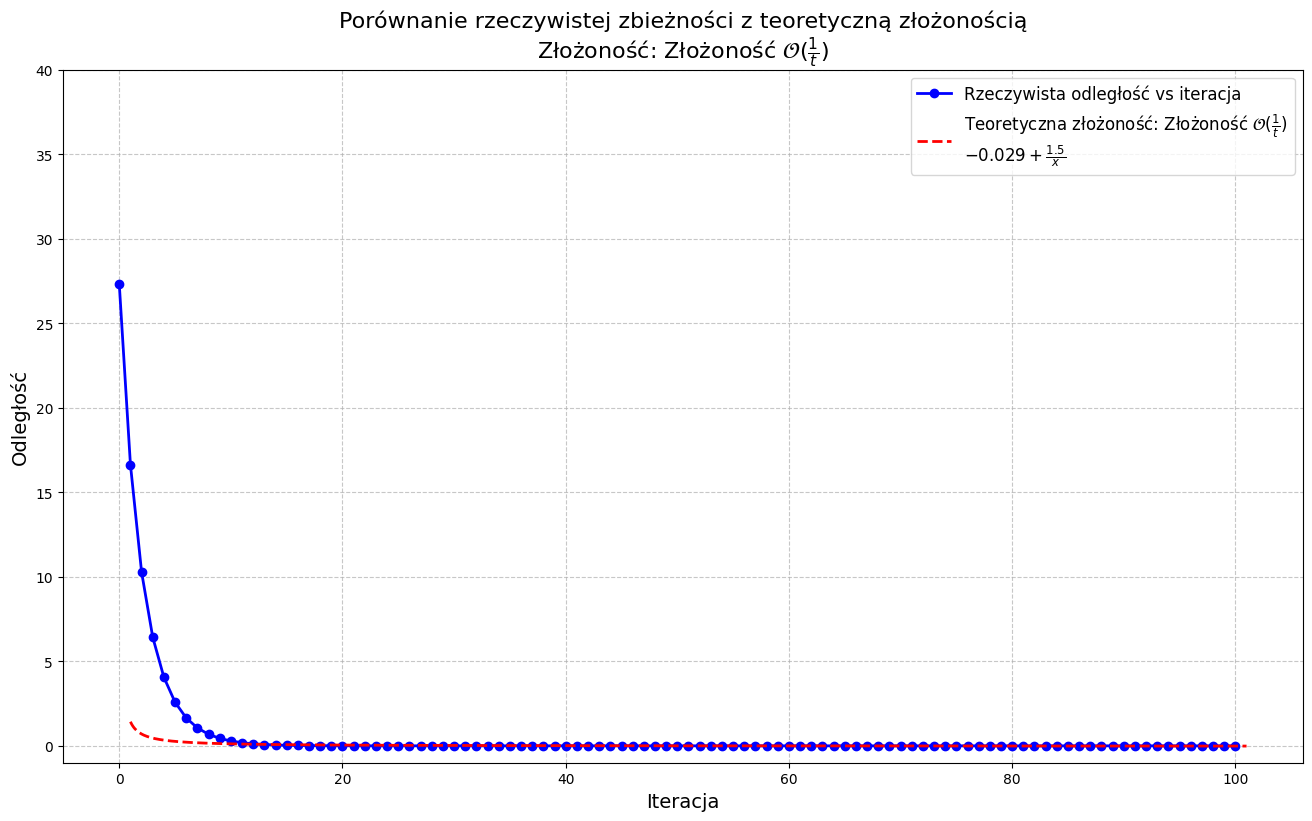

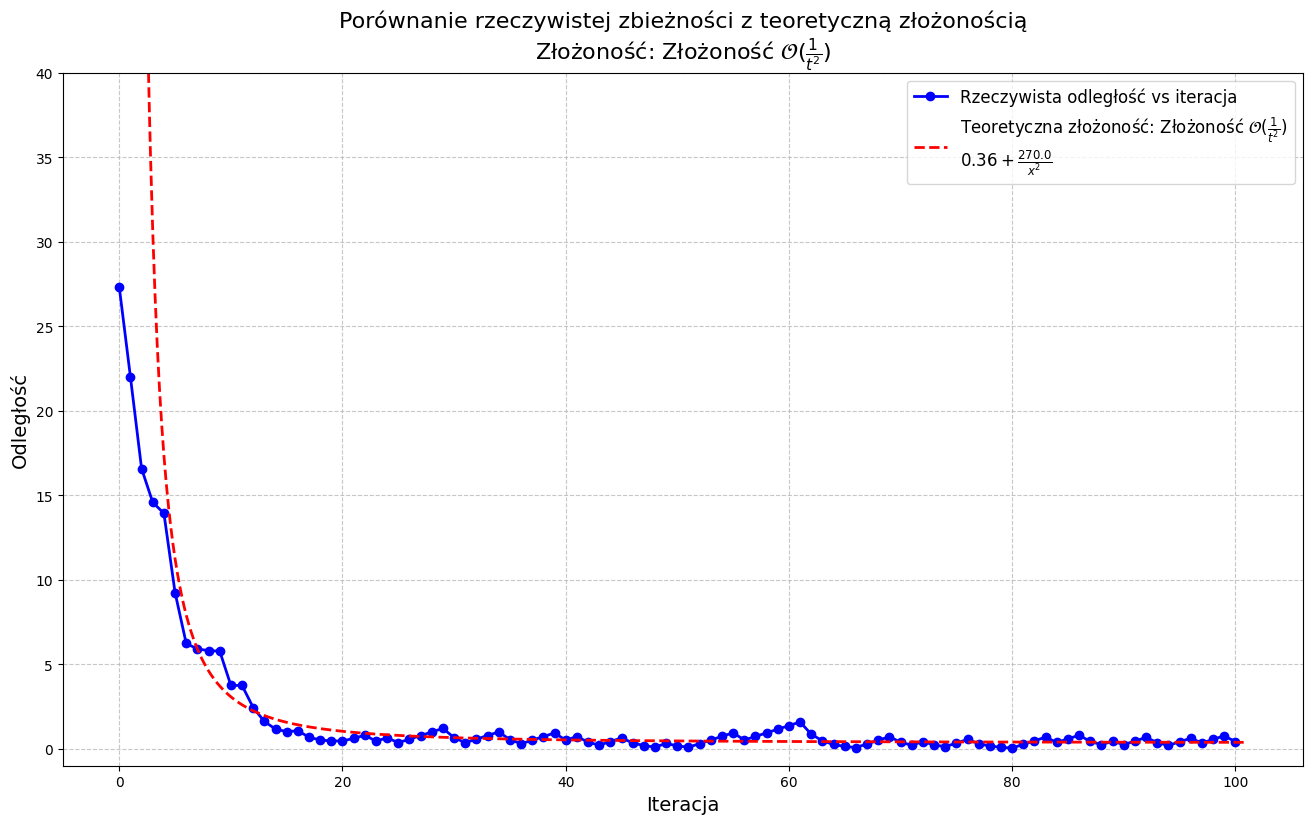

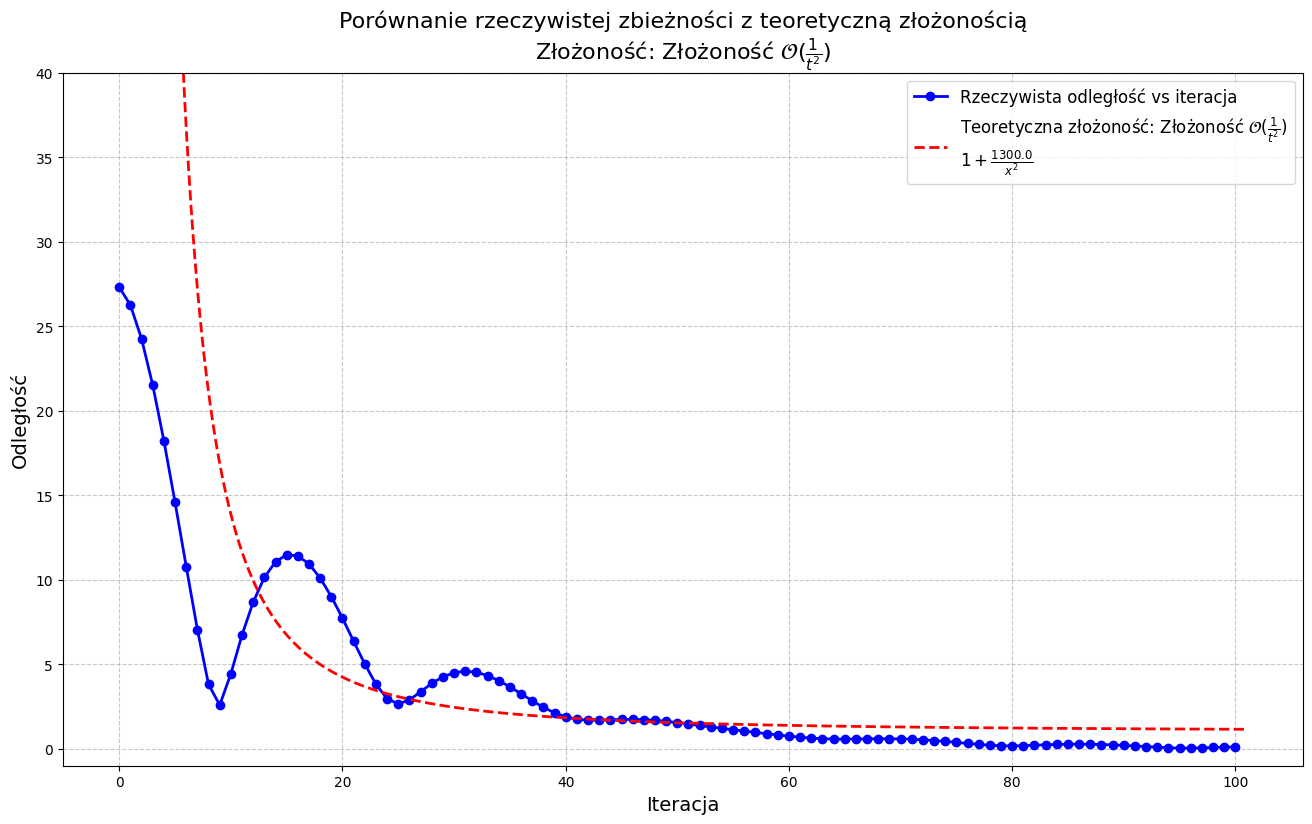

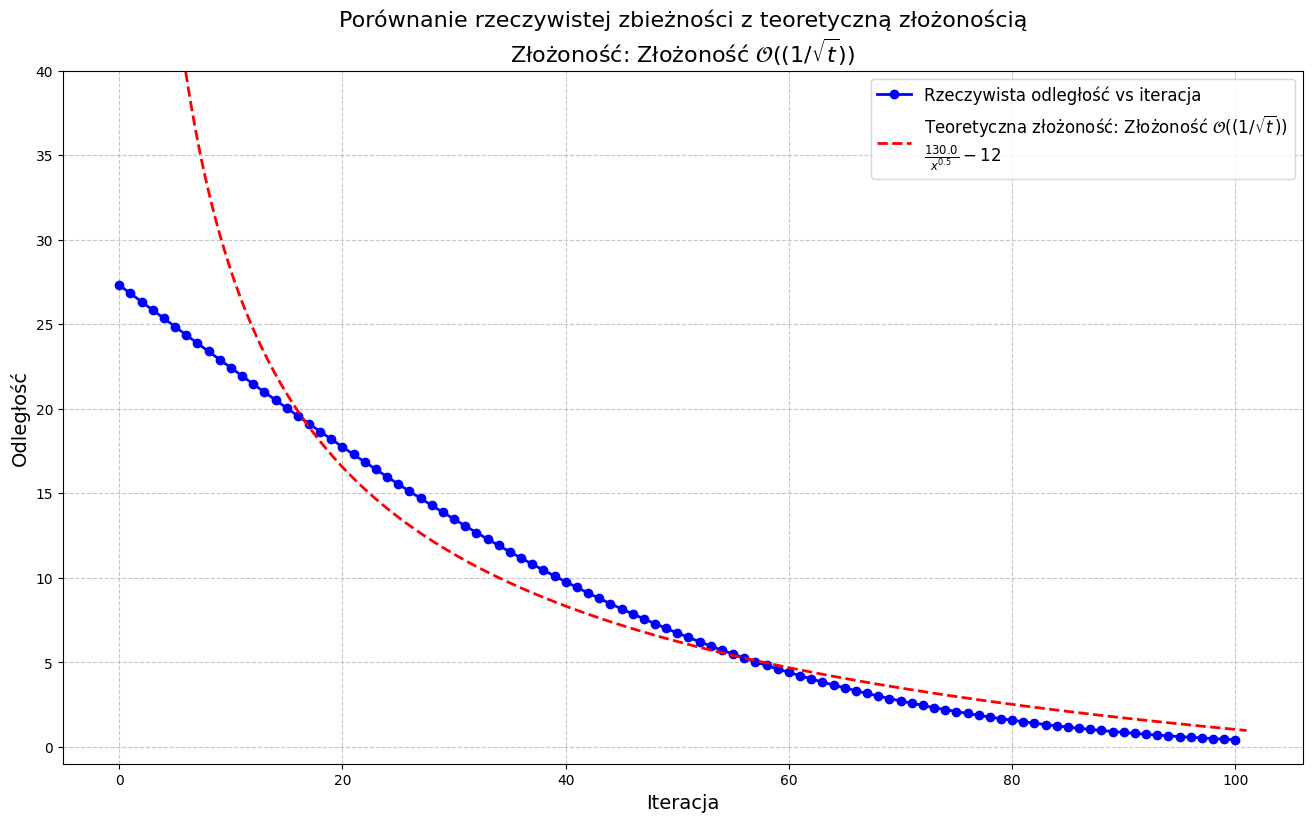

In [159]:
# parameters
learning_rate = 0.35
n_iter = 100
x_init = (21,-17)
x_final = (0, 0.47)

# creating function
x, y = sp.symbols('x y')
func_sp = 5/10 * (x**2 + 1.3 * (y- 0.47)**2)   
complexity_raport(x_init, x_final, func_sp, learning_rate, n_iter, None, b=0.9, b1=0.9, b2=0.999)

Presentation tests

Explaining parameters
- slow vs high learning ratio 
- momentum parameters 
- adam parameters

Problems with new methods
- Function with such gradient that we are jumping between minimum point 
- Function with such gradient that we can not enter to it (sparse data, very slow slope need of momentum)
- function that adam is much better than momentum, 

comparison 
- same function with all methods (we can join plots)
    - join plots with abs error 
    - on one plot every iteration step by step, (so we can see what is going on)
      

### Slajdy

#### porównanie zwykłego do momentum

##### problem ze zbieżnością przy małej pochodnej 

##### Problem z przeskakiwaniem przez punkt (moment powinen to rozwiązywać)

### Working Test 

In [ ]:
# parameters
learning_rate = 0.9
n_iter = 100
x_init = (3, 3)
x_final = (0, 0)

# creating function
x, y = sp.symbols('x y')
func_sp = x**2 + y**2  
complexity_raport(x_init, x_final, func_sp, learning_rate, n_iter, None)